<a href="https://colab.research.google.com/github/Pratikshaprabhakarbande/cifar-env-check/blob/main/Adversarial_Attacks_FGSM_PGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Install required packages
!pip install adversarial-robustness-toolbox tensorflow numpy matplotlib

# Suppress warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Import libraries
import numpy as np
from tensorflow import keras
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from art.estimators.classification import KerasClassifier
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("All packages imported successfully!")
print("GPU Available:", tf.config.list_physical_devices('GPU'))

All packages imported successfully!
GPU Available: []


In [10]:
# Attack implementation functions
def create_model(input_shape, num_classes):
    """Create a simple CNN model"""
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

def generate_adversarial_examples_fgsm(classifier, x, y, eps=0.1):
    """Generate FGSM adversarial examples"""
    attack = FastGradientMethod(estimator=classifier, eps=eps)
    return attack.generate(x=x)

def generate_adversarial_examples_pgd(classifier, x, y, eps=0.1, eps_step=0.01, max_iter=10):
    """Generate PGD adversarial examples"""
    attack = ProjectedGradientDescent(estimator=classifier, eps=eps,
                                    eps_step=eps_step, max_iter=max_iter, verbose=False)
    return attack.generate(x=x)

def evaluate_attack(model, x_clean, x_adv, y_true):
    """Evaluate attack success"""
    clean_preds = model.predict(x_clean, verbose=0)
    clean_acc = np.mean(np.argmax(clean_preds, axis=1) == np.argmax(y_true, axis=1))

    adv_preds = model.predict(x_adv, verbose=0)
    adv_acc = np.mean(np.argmax(adv_preds, axis=1) == np.argmax(y_true, axis=1))

    return clean_acc, adv_acc, 1 - adv_acc

def verify_on_samples(model, x_test, y_test, num_samples=50, eps=0.1):
    """Verify attacks on samples"""
    indices = np.random.choice(len(x_test), num_samples, replace=False)
    x_sample, y_sample = x_test[indices], y_test[indices]

    classifier = KerasClassifier(model=model, clip_values=(0, 1))

    print("Generating FGSM adversarial examples...")
    x_adv_fgsm = generate_adversarial_examples_fgsm(classifier, x_sample, y_sample, eps=eps)

    print("Generating PGD adversarial examples...")
    x_adv_pgd = generate_adversarial_examples_pgd(classifier, x_sample, y_sample, eps=eps)

    clean_acc_fgsm, adv_acc_fgsm, success_rate_fgsm = evaluate_attack(model, x_sample, x_adv_fgsm, y_sample)
    clean_acc_pgd, adv_acc_pgd, success_rate_pgd = evaluate_attack(model, x_sample, x_adv_pgd, y_sample)

    print("="*50)
    print(f"ATTACK RESULTS ON {num_samples} SAMPLES")
    print("="*50)
    print("FGSM Attack:")
    print(f"  Clean accuracy: {clean_acc_fgsm * 100:.2f}%")
    print(f"  Adversarial accuracy: {adv_acc_fgsm * 100:.2f}%")
    print(f"  Attack success rate: {success_rate_fgsm * 100:.2f}%")
    print("\nPGD Attack:")
    print(f"  Clean accuracy: {clean_acc_pgd * 100:.2f}%")
    print(f"  Adversarial accuracy: {adv_acc_pgd * 100:.2f}%")
    print(f"  Attack success rate: {success_rate_pgd * 100:.2f}%")
    print("="*50)

    return {
        'fgsm': {'x_adv': x_adv_fgsm, 'clean_acc': clean_acc_fgsm,
                'adv_acc': adv_acc_fgsm, 'success_rate': success_rate_fgsm},
        'pgd': {'x_adv': x_adv_pgd, 'clean_acc': clean_acc_pgd,
               'adv_acc': adv_acc_pgd, 'success_rate': success_rate_pgd},
        'x_clean': x_sample, 'y_clean': y_sample
    }

def visualize_results(results):
    """Visualize results"""
    x_clean = results['x_clean']
    x_adv_fgsm = results['fgsm']['x_adv']
    x_adv_pgd = results['pgd']['x_adv']

    num_examples = min(3, len(x_clean))
    indices = np.random.choice(len(x_clean), num_examples, replace=False)

    fig, axes = plt.subplots(num_examples, 4, figsize=(12, 3*num_examples))
    if num_examples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        axes[i, 0].imshow(x_clean[idx].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(x_adv_fgsm[idx].squeeze(), cmap='gray')
        axes[i, 1].set_title('FGSM Adversarial')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(x_adv_pgd[idx].squeeze(), cmap='gray')
        axes[i, 2].set_title('PGD Adversarial')
        axes[i, 2].axis('off')

        diff_fgsm = np.abs(x_adv_fgsm[idx] - x_clean[idx]).squeeze()
        axes[i, 3].imshow(diff_fgsm, cmap='hot')
        axes[i, 3].set_title('Difference')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

print("Attack functions defined successfully!")

Attack functions defined successfully!


In [11]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print("Data loaded and preprocessed!")
print(f"Training shape: {x_train.shape}, Test shape: {x_test.shape}")

Data loaded and preprocessed!
Training shape: (60000, 28, 28, 1), Test shape: (10000, 28, 28, 1)


Creating and training model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.8222 - loss: 0.6005 - val_accuracy: 0.9777 - val_loss: 0.0776
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - accuracy: 0.9780 - loss: 0.0716 - val_accuracy: 0.9872 - val_loss: 0.0454
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.9859 - loss: 0.0456 - val_accuracy: 0.9890 - val_loss: 0.0412
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.9894 - loss: 0.0352 - val_accuracy: 0.9873 - val_loss: 0.0472
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.9913 - loss: 0.0276 - val_accuracy: 0.9902 - val_loss: 0.0364
Test accuracy: 0.9903
Testing attacks on 50 samples...
Generating FGSM adversarial examples...
Generating PGD adversarial examples...
ATTACK RESULTS ON 50 SAMPLES
FGSM Attack:
  Clean accuracy: 98.00%
  Adversarial accuracy: 80.00%
  Attack success rate: 20.00%

PGD Attack:
  Clean accuracy: 98.00%
  Adversarial accuracy: 70.00%
  Attack success rate: 

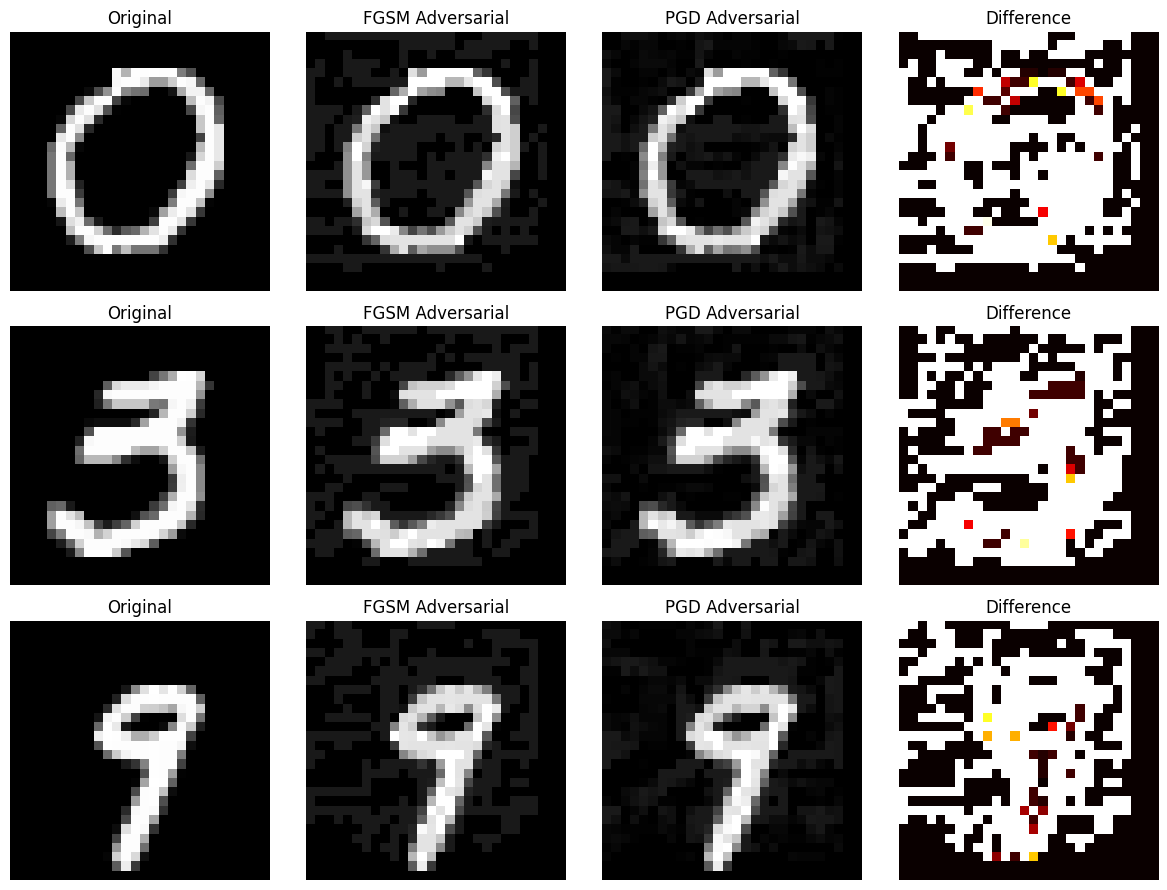

Attack implementation completed successfully!


In [12]:
# Train model and run attacks
print("Creating and training model...")
model = create_model(input_shape=(28, 28, 1), num_classes=10)

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

print("Testing attacks on 50 samples...")
results = verify_on_samples(model, x_test, y_test, num_samples=50, eps=0.1)

visualize_results(results)
print("Attack implementation completed successfully!")